<a href="https://colab.research.google.com/github/Zeeshan13/Colab_HuggingFace/blob/main/Module2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import models, datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import time

# Data loading and augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),  # Resizing to 224x224 for ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Reduced batch size for faster training
trainloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2)

# Load pre-trained ResNet-18 model
net = models.resnet18(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, 10)  # Customize the final layer for 10 classes (CIFAR-10)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# Check if CUDA is available for mixed precision training
use_cuda = torch.cuda.is_available()
if use_cuda:
    from torch.cuda.amp import GradScaler, autocast
    scaler = GradScaler()

# Training loop with validation and loss tracking
train_losses = []
val_losses = []

def train_model():
    best_val_loss = float('inf')
    patience = 5
    epochs_no_improve = 0
    n_epochs = 50  # Reduced from 100 to 50

    for epoch in range(n_epochs):
        start_time = time.time()
        net.train()
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            if use_cuda:
                with autocast():
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item()

            # Print progress for each batch
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{n_epochs}], Batch [{batch_idx+1}/{len(trainloader)}], Loss: {loss.item():.4f}")

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)

        val_loss = validate_model()
        val_losses.append(val_loss)

        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print("Early stopping!")
            break

def validate_model():
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            if use_cuda:
                with autocast():
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
            else:
                outputs = net(inputs)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(valloader)

# Start training
train_model()

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/50], Batch [1/196], Loss: 2.4523


KeyboardInterrupt: 

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Batch [1/63], Loss: 2.7924
Epoch [1/20], Train Loss: 2.0362, Validation Loss: 1.4644, Time: 249.69s
Epoch [2/20], Batch [1/63], Loss: 1.2206
Epoch [2/20], Train Loss: 1.1499, Validation Loss: 1.0124, Time: 248.24s
Epoch [3/20], Batch [1/63], Loss: 1.2078
Epoch [3/20], Train Loss: 0.8393, Validation Loss: 0.6990, Time: 253.33s
Epoch [4/20], Batch [1/63], Loss: 0.6960
Epoch [4/20], Train Loss: 0.5719, Validation Loss: 0.6527, Time: 254.40s
Epoch [5/20], Batch [1/63], Loss: 0.3095
Epoch [5/20], Train Loss: 0.4397, Validation Loss: 0.6148, Time: 255.42s
Epoch [6/20], Batch [1/63], Loss: 0.6459
Epoch [6/20], Train Loss: 0.3608, Validation Loss: 0.6603, Time: 249.90s
Epoch [7/20], Batch [1/63], Loss: 0.4126
Epoch [7/20], Train Loss: 0.2646, Validation Loss: 0.5384, Time: 252.61s
Epoch [8/20], Batch [1/63], Loss: 0.1392
Epoch [8/20], Train Loss: 0.2157, Validation Loss: 0.5405, Time: 252.39s
Epoch [9/20]

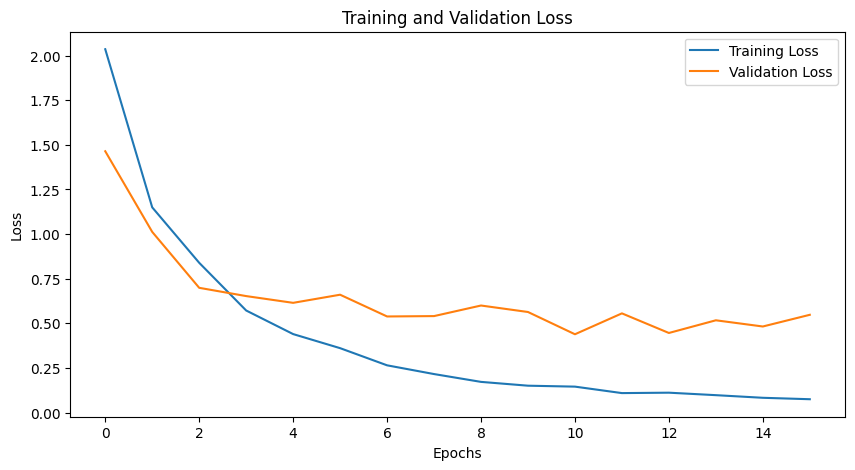

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import models, datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import time
import numpy as np

# Data loading and augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),  # Resizing to 224x224 for ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create small sample datasets
np.random.seed(0)
train_indices = np.random.choice(len(train_dataset), 1000, replace=False)
val_indices = np.random.choice(len(val_dataset), 200, replace=False)

small_train_dataset = Subset(train_dataset, train_indices)
small_val_dataset = Subset(val_dataset, val_indices)

# Reduced batch size for faster training
trainloader = DataLoader(small_train_dataset, batch_size=16, shuffle=True, num_workers=2)
valloader = DataLoader(small_val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Load pre-trained ResNet-18 model
net = models.resnet18(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, 10)  # Customize the final layer for 10 classes (CIFAR-10)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# Check if CUDA is available for mixed precision training
use_cuda = torch.cuda.is_available()
if use_cuda:
    from torch.cuda.amp import GradScaler, autocast
    scaler = GradScaler()

# Training loop with validation and loss tracking
train_losses = []
val_losses = []

def train_model():
    best_val_loss = float('inf')
    patience = 5
    epochs_no_improve = 0
    n_epochs = 20  # Reduced from 100 to 20 for quicker training

    for epoch in range(n_epochs):
        start_time = time.time()
        net.train()
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            if use_cuda:
                with autocast():
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item()

            # Print progress for each batch
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{n_epochs}], Batch [{batch_idx+1}/{len(trainloader)}], Loss: {loss.item():.4f}")

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)

        val_loss = validate_model()
        val_losses.append(val_loss)

        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print("Early stopping!")
            break

def validate_model():
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            if use_cuda:
                with autocast():
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
            else:
                outputs = net(inputs)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(valloader)

# Start training
train_model()

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Create small sample datasets
np.random.seed(0)
train_indices = np.random.choice(len(train_dataset), 500, replace=False)
val_indices = np.random.choice(len(val_dataset), 50, replace=False)

small_train_dataset = Subset(train_dataset, train_indices)
small_val_dataset = Subset(val_dataset, val_indices)

# Reduced batch size for faster training
trainloader = DataLoader(small_train_dataset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(small_val_dataset, batch_size=64, shuffle=False, num_workers=2)

# Load pre-trained ResNet-18 model
net = models.resnet18(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, 10)  # Customize the final layer for 10 classes (CIFAR-10)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# Check if CUDA is available for mixed precision training
use_cuda = torch.cuda.is_available()
if use_cuda:
    from torch.cuda.amp import GradScaler, autocast
    scaler = GradScaler()

# Training loop with validation and loss tracking
train_losses = []
val_losses = []# Training loop with validation and loss tracking
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    corrects = torch.sum(preds == labels.data)
    return corrects.double() / len(labels)

def train_model():
    best_val_loss = float('inf')
    patience = 5
    epochs_no_improve = 0
    n_epochs = 10  # Reduced from 100 to 20 for quicker training

    for epoch in range(n_epochs):
        start_time = time.time()
        net.train()
        running_loss = 0.0
        running_corrects = 0
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            if use_cuda:
                with autocast():
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item()
            running_corrects += calculate_accuracy(outputs, labels) * len(labels)

            # Print progress for each batch
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{n_epochs}], Batch [{batch_idx+1}/{len(trainloader)}], Loss: {loss.item():.4f}")

        train_loss = running_loss / len(trainloader)
        train_acc = running_corrects / len(trainloader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc = validate_model()
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print("Early stopping!")
            break

def validate_model():
    net.eval()
    val_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            if use_cuda:
                with autocast():
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
            else:
                outputs = net(inputs)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            running_corrects += calculate_accuracy(outputs, labels) * len(labels)
    val_loss /= len(valloader)
    val_acc = running_corrects / len(valloader.dataset)
    return val_loss, val_acc

# Start training
train_model()

Epoch [1/10], Batch [1/8], Loss: 2.4718
Epoch [1/10], Train Loss: 2.4000, Train Acc: 0.1020, Validation Loss: 2.3599, Validation Acc: 0.1000, Time: 137.96s
Epoch [2/10], Batch [1/8], Loss: 2.3306
Epoch [2/10], Train Loss: 2.2126, Train Acc: 0.1720, Validation Loss: 2.1218, Validation Acc: 0.3000, Time: 139.15s
Epoch [3/10], Batch [1/8], Loss: 1.9988
Epoch [3/10], Train Loss: 1.9948, Train Acc: 0.2960, Validation Loss: 1.9281, Validation Acc: 0.2200, Time: 138.28s
Epoch [4/10], Batch [1/8], Loss: 1.9051
Epoch [4/10], Train Loss: 1.7658, Train Acc: 0.4700, Validation Loss: 1.7657, Validation Acc: 0.4200, Time: 139.15s
Epoch [5/10], Batch [1/8], Loss: 1.6735
Epoch [5/10], Train Loss: 1.5648, Train Acc: 0.5660, Validation Loss: 1.6100, Validation Acc: 0.5200, Time: 139.23s
Epoch [6/10], Batch [1/8], Loss: 1.4674
Epoch [6/10], Train Loss: 1.3744, Train Acc: 0.6260, Validation Loss: 1.4482, Validation Acc: 0.5200, Time: 139.83s
Epoch [7/10], Batch [1/8], Loss: 1.2157
Epoch [7/10], Train Loss

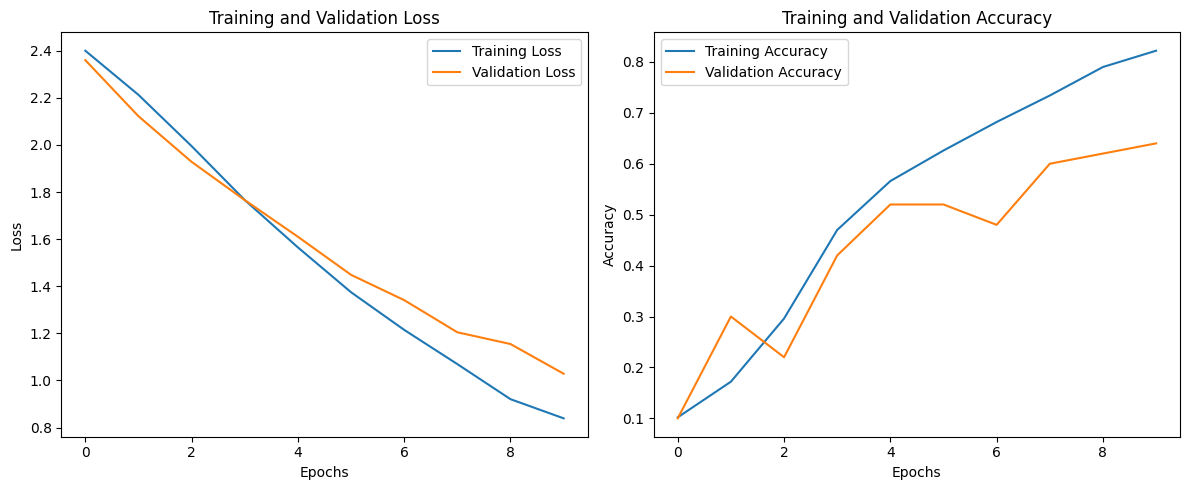

In [ ]:
# Plotting the training and validation losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()